In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
# process 2018 tax help data
ato2016_data = pd.read_excel("atoabsgovhack2018.xlsx", sheet_name="ATO Data")
abs2016_data = pd.read_excel("atoabsgovhack2018.xlsx", sheet_name="ABS Data")
txc_data = pd.read_excel("atoabsgovhack2018.xlsx", sheet_name="Tax Help Center")
txc_data.rename(columns={'Post Code': 'Postcode'}, inplace=True)
seifa_data = pd.read_excel("atoabsgovhack2018.xlsx", sheet_name="ABS SEIFA ").convert_objects(convert_numeric=True)
seifa_data.rename(columns={'Postal Area (POA) Code': 'Postcode'}, inplace=True)
seifa_data.rename(columns={'Year': 'Income year'}, inplace=True)
seifa_data["Income year"] = seifa_data["Income year"].apply(lambda x: 2015 if x == 2011 else x)
seifa_data.replace(to_replace='-', value=0, inplace=True)

# process 2017 tax help data
ato2015_data = pd.read_excel("atoabsgovhack2017.xlsx", sheet_name="Data", skiprows=0, usecols=[0,1,2,*range(3, 17)])
ato2015_data = ato2015_data.loc[ato2015_data['Income year'] == 2015]
abs2015_data = pd.read_excel("atoabsgovhack2017.xlsx", sheet_name="Data", skiprows=0, usecols=[0,1,2,*range(17, 56)])
abs2015_data = abs2015_data.loc[abs2015_data['Income year'] == 2015]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [3]:
# process 2016 ato stats
df = pd.read_excel("taxstats2016individual06taxablestatusstateterritorypostcodetaxableincome.xlsx", sheet_name="Individuals Table 6B", skiprows=2, usecols=[1, 2, 4, 37, 39, 85, 93, 107, 129])
ato2016_stats = pd.DataFrame()
ato2016_stats['average income per person'] = df[df.columns[2]]/df[df.columns[1]]
ato2016_stats['unfranked ratio'] = df[df.columns[3]]/df[df.columns[1]]
ato2016_stats['franked ratio'] = df[df.columns[4]]/df[df.columns[1]]
ato2016_stats['cgt ratio'] = df[df.columns[5]]/df[df.columns[1]]
ato2016_stats['foreign income ratio'] = df[df.columns[6]]/df[df.columns[1]]
ato2016_stats['rent ratio'] = df[df.columns[7]]/df[df.columns[1]]
ato2016_stats['business ratio'] = df[df.columns[8]]/df[df.columns[1]]
ato2016_stats['Postcode'] = df['Postcode']
ato2016_stats = ato2016_stats.loc[ato2016_stats['Postcode'].isin(list(range(100,9999)))]
ato2016_stats['Postcode'] = ato2016_stats['Postcode'].astype(np.int64)
ato2016_stats['Income year'] = 2016

# process 2015 ato stats
df = pd.read_excel("taxstats2015individual06taxablestatusstateterritorypostcode.xlsx", sheet_name="Individuals Table 6B", skiprows=2, usecols=[1, 2, 4, 37, 39, 79, 87, 101, 123])
ato2015_stats = pd.DataFrame()
ato2015_stats['average income per person'] = df[df.columns[2]]/df[df.columns[1]]
ato2015_stats['unfranked ratio'] = df[df.columns[3]]/df[df.columns[1]]
ato2015_stats['franked ratio'] = df[df.columns[4]]/df[df.columns[1]]
ato2015_stats['cgt ratio'] = df[df.columns[5]]/df[df.columns[1]]
ato2015_stats['foreign income ratio'] = df[df.columns[6]]/df[df.columns[1]]
ato2015_stats['rent ratio'] = df[df.columns[7]]/df[df.columns[1]]
ato2015_stats['business ratio'] = df[df.columns[8]]/df[df.columns[1]]
ato2015_stats['Postcode'] = df['Postcode']
ato2015_stats = ato2015_stats.loc[ato2015_stats['Postcode'].isin(list(range(100,9999)))]
ato2015_stats['Postcode'] = ato2015_stats['Postcode'].astype(np.int64)
ato2015_stats['Income year'] = 2015

In [5]:
# join datasets
df = pd.DataFrame()
df = df.append(ato2016_data)
df = df.append(ato2015_data)
abs_data = abs2016_data.append(abs2015_data)
df = df.merge(abs_data, on=["Income year", "Postcode"], how="outer")
ato_stats = ato2016_stats.append(ato2015_stats)
df = df.merge(ato_stats, on=["Income year", "Postcode"], how="outer")
df = df.merge(seifa_data, on=["Income year", "Postcode"], how="outer")
df = df.merge(txc_data, on="Postcode", how="outer")
df.fillna(0, inplace=True)
# TEMPORARY: limit to 2015/2016 data
df = df[df['Income year'].isin([2016, 2015])]
df.head()

,id_x,Income year,Postcode,Individuals1,Taxable income or loss1,Net tax,Gross interest,Net rent,Net capital gain,Total income or loss,...,cgt ratio,foreign income ratio,rent ratio,business ratio,Index of Relative Socio-economic Advantage and Disadvantage,Index of Relative Socio-economic Disadvantage,Index of Economic Resources,Index of Education and Occupation,Usual Resident Population,Count
2,201600800.0,2016.0,800,5464.0,3.893756e+08,101020407.0,2146701.0,-4580471.0,2352866.0,4.019841e+08,...,0.022328,0.026537,0.037518,0.042277,1096.0,1066.0,946.0,1089.0,6464.0,0.0
3,201500800.0,2015.0,800,5579.0,3.458534e+08,83997228.0,2280912.0,-4125084.0,3027094.0,3.585177e+08,...,0.022585,0.023839,0.037103,0.044452,1072.0,1060.0,952.0,1077.0,4564.0,0.0
6,201600810.0,2016.0,810,21128.0,1.367380e+09,315901076.0,9757680.0,-17414593.0,8046750.0,1.423396e+09,...,0.028446,0.037344,0.061246,0.084154,1052.0,1037.0,1014.0,1045.0,33302.0,1.0
7,201500810.0,2015.0,810,20792.0,1.326501e+09,302144669.0,11336449.0,-14253016.0,10798280.0,1.381329e+09,...,0.029434,0.035879,0.062716,0.086235,1037.0,1027.0,1008.0,1051.0,29725.0,1.0
10,201600812.0,2016.0,812,11509.0,7.282063e+08,162280073.0,4232709.0,-10799838.0,2549416.0,7.552301e+08,...,0.026327,0.034669,0.057694,0.073073,1020.0,1013.0,1013.0,997.0,18873.0,1.0


In [6]:
# specify features columns
features = df.columns[3:-3]
df[features].columns

# feature correlations
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    count_corr = df[['Count'] + list(features)].corr(method='pearson')['Count']
    display(count_corr[count_corr > 0.5])

Count          1.00000
Not married    0.50443
Name: Count, dtype: float64

In [7]:
# create label column and train/test split
df['label'] = df['Count']
# df['label'] = (df['Count'] > 1).astype(np.int64)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .80
train, test = df[df['is_train']==True], df[df['is_train']==False]
print("Train Class Balance:", train[train['label']==0].shape[0], " / ", train[train['label']==1].shape[0])
print("Test Class Balance:", test[test['label']==0].shape[0], " / ", test[test['label']==1].shape[0])
train.head()

Train Class Balance: 3373  /  668
Test Class Balance: 910  /  134


,id_x,Income year,Postcode,Individuals1,Taxable income or loss1,Net tax,Gross interest,Net rent,Net capital gain,Total income or loss,...,rent ratio,business ratio,Index of Relative Socio-economic Advantage and Disadvantage,Index of Relative Socio-economic Disadvantage,Index of Economic Resources,Index of Education and Occupation,Usual Resident Population,Count,label,is_train
2,201600800.0,2016.0,800,5464.0,3.893756e+08,101020407.0,2146701.0,-4580471.0,2352866.0,4.019841e+08,...,0.037518,0.042277,1096.0,1066.0,946.0,1089.0,6464.0,0.0,0.0,True
3,201500800.0,2015.0,800,5579.0,3.458534e+08,83997228.0,2280912.0,-4125084.0,3027094.0,3.585177e+08,...,0.037103,0.044452,1072.0,1060.0,952.0,1077.0,4564.0,0.0,0.0,True
7,201500810.0,2015.0,810,20792.0,1.326501e+09,302144669.0,11336449.0,-14253016.0,10798280.0,1.381329e+09,...,0.062716,0.086235,1037.0,1027.0,1008.0,1051.0,29725.0,1.0,1.0,True
10,201600812.0,2016.0,812,11509.0,7.282063e+08,162280073.0,4232709.0,-10799838.0,2549416.0,7.552301e+08,...,0.057694,0.073073,1020.0,1013.0,1013.0,997.0,18873.0,1.0,1.0,True
11,201500812.0,2015.0,812,11640.0,7.351788e+08,162016768.0,5336982.0,-9507909.0,4041359.0,7.632562e+08,...,0.062457,0.076117,1019.0,1013.0,1015.0,1007.0,19334.0,1.0,1.0,True


In [8]:
# build predictive model
rf = RandomForestClassifier(class_weight='balanced', n_estimators=1000, oob_score=True)
rf.fit(train[features], train['label'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [9]:
# model accuracy (out of bag and test set)
accuracy = accuracy_score(test['label'], rf.predict(test[features]))
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

# model accuracy (cross validation)
kfold = KFold(n_splits=10)
scores = cross_val_score(rf, train[features], train['label'], cv=kfold)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Out-of-bag score estimate: 0.935
Mean accuracy score: 0.945


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.80 (+/- 0.04)


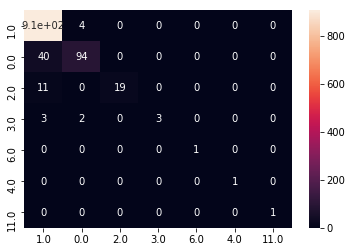

In [10]:
# confusion matrix for test set
cm = pd.DataFrame(confusion_matrix(test['label'], rf.predict(test[features])), columns=test['label'].unique(), index=test['label'].unique())
sns.heatmap(cm, annot=True)

In [11]:
# top ten features
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train[features], list(rf.feature_importances_))]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:50} Importance: {}'.format(*pair)) for pair in feature_importances[:10]];

Variable: North-East Asian                         Importance: 0.05
Variable: 20-24 years                              Importance: 0.04
Variable: South-East Asian                         Importance: 0.04
Variable: Index of Economic Resources              Importance: 0.04
Variable: Oceanian                                 Importance: 0.03
Variable: under or 0                               Importance: 0.03
Variable: 1000-1999                                Importance: 0.03
Variable: Index of Relative Socio-economic Disadvantage Importance: 0.03
Variable: Individuals1                             Importance: 0.02
Variable: 0-4 years                                Importance: 0.02
